# Training a Image Classifier for Fashion MNIST Dataset

Shaw And Partners Coding Challenge

Matheus de Andrade Silva

## Dependencies

In [3]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline  

## Import Data

In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms

In [5]:
# Download FashionMNIST dataset

# Transform the data from range [0, 255] to range [0.0, 1.0]
transform = transforms.Compose([transforms.ToTensor()])

train_set = FashionMNIST(root='data/', train=True, download=True, transform=transform)
test_set =  FashionMNIST(root='data/', train=False, download=True, transform=transform)

In [6]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = (train_set.data, train_set.targets), (test_set.data, test_set.targets)

In [7]:
print('>> Train test size analysis:')
print('Train images shape:', X_train_raw.shape)
print('Train labels shape:', y_train_raw.shape)
print('Test images shape:', X_test_raw.shape)
print('Test labels shape:', y_test_raw.shape)

>> Train test size analysis:
Train images shape: torch.Size([60000, 28, 28])
Train labels shape: torch.Size([60000])
Test images shape: torch.Size([10000, 28, 28])
Test labels shape: torch.Size([10000])


## Data Analysis

In [8]:
print('>> Train label distribution analysis:')
for value in np.array(np.unique(y_train_raw, return_counts=True)).T:
    print(f'Label: {value[0]}, Count: {value[1]}')

>> Train label distribution analysis:
Label: 0, Count: 6000
Label: 1, Count: 6000
Label: 2, Count: 6000
Label: 3, Count: 6000
Label: 4, Count: 6000
Label: 5, Count: 6000
Label: 6, Count: 6000
Label: 7, Count: 6000
Label: 8, Count: 6000
Label: 9, Count: 6000


In [9]:

print('>> Test label distribution analysis:')
for value in np.array(np.unique(y_test_raw, return_counts=True)).T:
    print(f'Label: {value[0]}, Count: {value[1]}')

>> Test label distribution analysis:
Label: 0, Count: 1000
Label: 1, Count: 1000
Label: 2, Count: 1000
Label: 3, Count: 1000
Label: 4, Count: 1000
Label: 5, Count: 1000
Label: 6, Count: 1000
Label: 7, Count: 1000
Label: 8, Count: 1000
Label: 9, Count: 1000


>> Image examples:


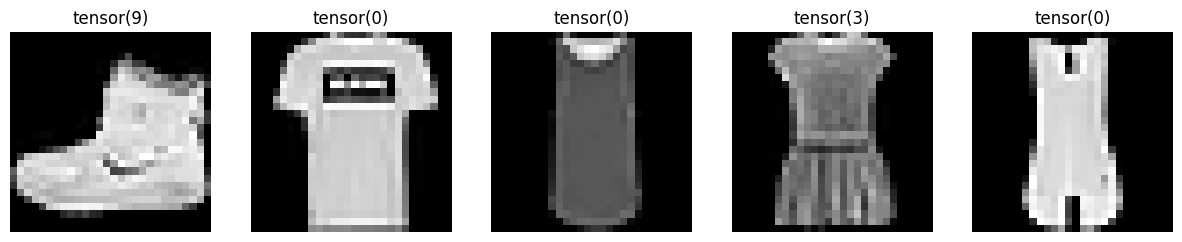

In [10]:
print('>> Image examples:')
fig, axes = plt.subplots(1, 5, figsize=(15,15))
for i in range(5):
    axes[i].imshow(X_train_raw[i], cmap='gray')
    axes[i].set_title(y_train_raw[i])
    axes[i].axis('off')

In [11]:
print('>> Image array data analysis:')
print(f'Image array shape: {X_train_raw[0].shape}')
print(f'Total pixels: {X_train_raw[0].shape[0] * X_train_raw[0].shape[1]}')
print(f'Min value: {X_train_raw[0].min()}')
print(f'Max value: {X_train_raw[0].max()}')

>> Image array data analysis:
Image array shape: torch.Size([28, 28])
Total pixels: 784
Min value: 0
Max value: 255


## Data Handling

In [15]:
from torch.utils.data import random_split, Subset
import torch

In [16]:
# Change the pixel values range from 0-255 to 0-1
train_set.data = train_set.data.type(torch.float32) / 255
test_set.data = test_set.data.type(torch.float32) / 255
print(f'Max value: {train_set.data[0].max()}')

Max value: 1.0


In [17]:
# Create a validation set
train_set, val_set = random_split(train_set, [50000, 10000])

## Training

In [52]:
from torch import nn
from torch import optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [172]:
# Some useful constants
IMAGE_SIZE = 28*28
IMAGE_LENGTH = 28
DEVICE = 'cpu'
print (f'Using {DEVICE} device')

Using cpu device


In [48]:
def get_classification_report(test_set, model):
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    y_pred = []
    y_true = []

    for X, y in test_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        y_pred.extend(model(X).argmax(dim=1).tolist())
        y_true.extend(y.tolist())

    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks(np.arange(10))
    plt.yticks(np.arange(10))
    plt.title('Confusion matrix ')
    plt.colorbar()
    plt.show()
    

In [138]:
def train(model, train_set, valid_set, opt, loss_fn, epochs=20, batch_size=64):
    """
    Train a model and evaluate it at every epoch.
    
    Args:
        model: a pytorch model
        train_set: dataset to train on
        valid_set: dataset to evaluate on
        opt: a pytorch optimizer
        loss_fn: a pytorch loss function
        epochs: number of epochs to train
    """
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(214))
    val_loader = DataLoader(valid_set, batch_size=len(valid_set),shuffle=True, generator=torch.manual_seed(214))

    X_val, y_val = next(iter(val_loader))
    X_val = X_val.to(DEVICE)
    y_val = y_val.to(DEVICE)

    for epoch in range(epochs):
        for batch in train_loader:
            X, y = batch
            X = X.to(DEVICE)
            y = y.to(DEVICE)

            # Forward pass
            outputs = model(X)
            loss = loss_fn(outputs, y)
            
            # Backward and optimize
            opt.zero_grad()
            loss.backward()
            opt.step()

        # Evaluate
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = loss_fn(model(X_val), y_val)
            print(f'>>> Epoch: {epoch+1}, train_loss: {loss.item()}, val_loss: {val_loss.item()}, val_accy: {accuracy_score(y_val, y_val_pred.argmax(dim=1))}')
    

### Simple Multilayer Perceptron Network 

#### 1st model

In [139]:
class FashionMNISTModel_MLP_3(nn.Module):
    def __init__(self):
        super(FashionMNISTModel_MLP_3, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(IMAGE_SIZE, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)

In [140]:
clf_mlp_3 = FashionMNISTModel_MLP_3().to(DEVICE)
opt = optim.Adam(clf_mlp_3.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train(clf_mlp_3, train_set, val_set, opt, loss_fn, epochs=50, batch_size=32)

>>> Epoch: 1, train_loss: 0.8082671165466309, val_loss: 0.9061436653137207, val_accy: 0.6306
>>> Epoch: 2, train_loss: 0.8556883931159973, val_loss: 0.803689181804657, val_accy: 0.6824
>>> Epoch: 3, train_loss: 0.31345513463020325, val_loss: 0.7882031202316284, val_accy: 0.6839
>>> Epoch: 4, train_loss: 0.6545161008834839, val_loss: 0.7621808648109436, val_accy: 0.6905
>>> Epoch: 5, train_loss: 0.7281733155250549, val_loss: 0.7847938537597656, val_accy: 0.6875
>>> Epoch: 6, train_loss: 0.9163058400154114, val_loss: 0.7978619337081909, val_accy: 0.6628
>>> Epoch: 7, train_loss: 0.7434251308441162, val_loss: 0.7588438987731934, val_accy: 0.6928
>>> Epoch: 8, train_loss: 0.8443180918693542, val_loss: 0.7673724293708801, val_accy: 0.6864
>>> Epoch: 9, train_loss: 0.6756967902183533, val_loss: 0.7492477297782898, val_accy: 0.7013
>>> Epoch: 10, train_loss: 0.40378931164741516, val_loss: 0.7528548240661621, val_accy: 0.6788
>>> Epoch: 11, train_loss: 0.4971435070037842, val_loss: 0.758074700

KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.66      0.44      0.53      1000
           1       0.94      0.92      0.93      1000
           2       0.50      0.62      0.55      1000
           3       0.78      0.77      0.77      1000
           4       0.58      0.71      0.64      1000
           5       0.82      0.35      0.49      1000
           6       0.53      0.49      0.51      1000
           7       0.56      0.93      0.70      1000
           8       0.94      0.88      0.91      1000
           9       0.83      0.82      0.83      1000

    accuracy                           0.69     10000
   macro avg       0.71      0.69      0.68     10000
weighted avg       0.71      0.69      0.68     10000



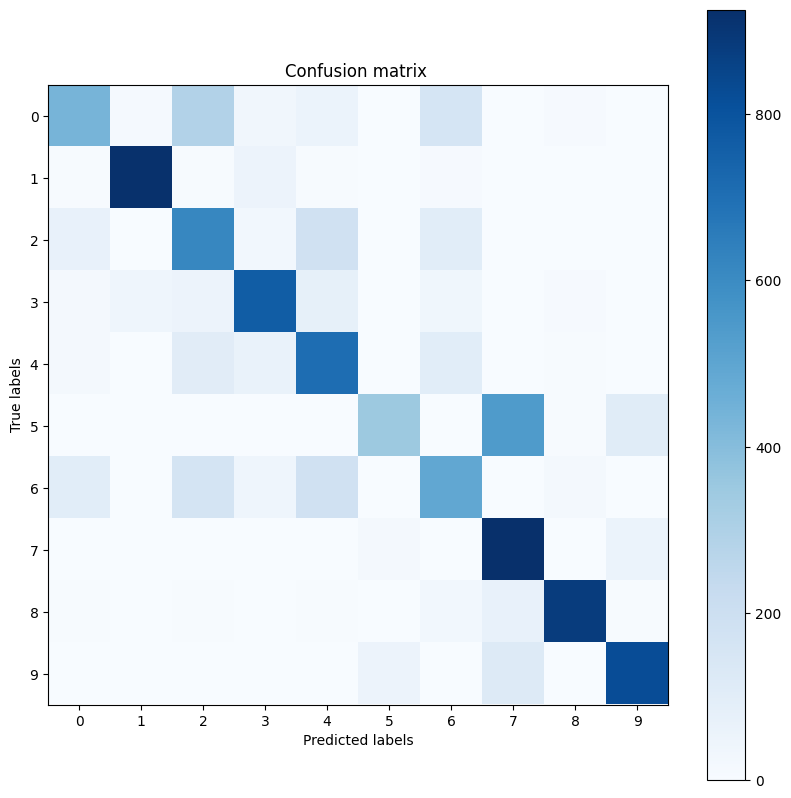

In [165]:
get_classification_report(test_set, clf_mlp_3)

#### 2nd model

In [141]:
class FashionMNISTModel_MLP_5(nn.Module):
    def __init__(self):
        super(FashionMNISTModel_MLP_5, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(IMAGE_SIZE, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)

In [167]:
clf_mlp_5 = FashionMNISTModel_MLP_5().to(DEVICE)
opt = optim.Adam(clf_mlp_5.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train(clf_mlp_5, train_set, val_set, opt, loss_fn, epochs=30, batch_size=32)

>>> Epoch: 1, train_loss: 0.7231698632240295, val_loss: 0.858473539352417, val_accy: 0.6457
>>> Epoch: 2, train_loss: 0.8880947828292847, val_loss: 0.7906649708747864, val_accy: 0.683
>>> Epoch: 3, train_loss: 0.2492758333683014, val_loss: 0.7796581387519836, val_accy: 0.6873
>>> Epoch: 4, train_loss: 0.5997809171676636, val_loss: 0.7642827033996582, val_accy: 0.6935
>>> Epoch: 5, train_loss: 0.7040863633155823, val_loss: 0.7638300061225891, val_accy: 0.694
>>> Epoch: 6, train_loss: 0.8163241744041443, val_loss: 0.7805581092834473, val_accy: 0.6834
>>> Epoch: 7, train_loss: 0.7446735501289368, val_loss: 0.760921061038971, val_accy: 0.6887
>>> Epoch: 8, train_loss: 0.8827888369560242, val_loss: 0.8175107836723328, val_accy: 0.6805


KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.63      0.53      0.58      1000
           1       0.94      0.88      0.91      1000
           2       0.54      0.56      0.55      1000
           3       0.69      0.85      0.76      1000
           4       0.62      0.61      0.61      1000
           5       0.81      0.35      0.49      1000
           6       0.53      0.50      0.52      1000
           7       0.56      0.91      0.69      1000
           8       0.93      0.87      0.90      1000
           9       0.82      0.82      0.82      1000

    accuracy                           0.69     10000
   macro avg       0.71      0.69      0.68     10000
weighted avg       0.71      0.69      0.68     10000



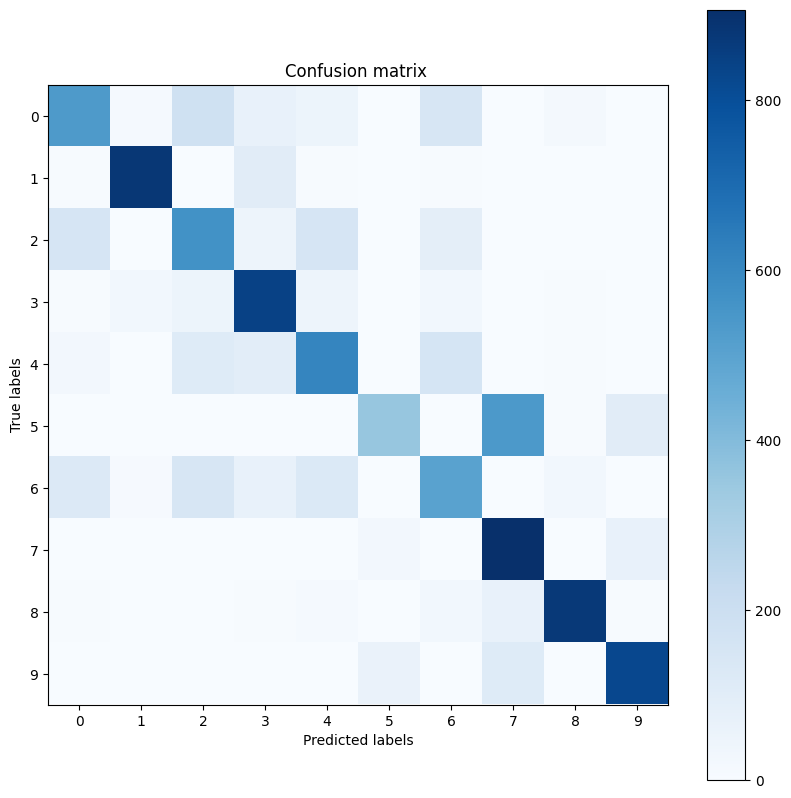

In [168]:
get_classification_report(test_set, clf_mlp_5)

### CNN

#### 1st model

In [161]:
class FashionMNISTModel_CNN_2(nn.Module):
    def __init__(self):
        super(FashionMNISTModel_CNN_2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Flatten(),
            nn.Linear(4*4*50, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

In [162]:
clf_cnn_2 = FashionMNISTModel_CNN_2().to(DEVICE)
opt = optim.Adam(clf_cnn_2.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train(clf_cnn_2, train_set, val_set, opt, loss_fn, epochs=25, batch_size=32)

>>> Epoch: 1, train_loss: 0.9322637319564819, val_loss: 0.8581411242485046, val_accy: 0.6549
>>> Epoch: 2, train_loss: 1.0665812492370605, val_loss: 0.8034231662750244, val_accy: 0.6815
>>> Epoch: 3, train_loss: 0.31099581718444824, val_loss: 0.7475652098655701, val_accy: 0.6992
>>> Epoch: 4, train_loss: 0.6864834427833557, val_loss: 0.7260258197784424, val_accy: 0.7124
>>> Epoch: 5, train_loss: 0.7272046804428101, val_loss: 0.7280558347702026, val_accy: 0.7061
>>> Epoch: 6, train_loss: 0.7360848188400269, val_loss: 0.7427030205726624, val_accy: 0.7064


KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.60      0.59      0.59      1000
           1       0.92      0.93      0.92      1000
           2       0.58      0.55      0.56      1000
           3       0.75      0.81      0.78      1000
           4       0.61      0.68      0.65      1000
           5       0.72      0.39      0.50      1000
           6       0.57      0.48      0.52      1000
           7       0.56      0.92      0.69      1000
           8       0.93      0.88      0.91      1000
           9       0.86      0.76      0.81      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.69     10000
weighted avg       0.71      0.70      0.69     10000



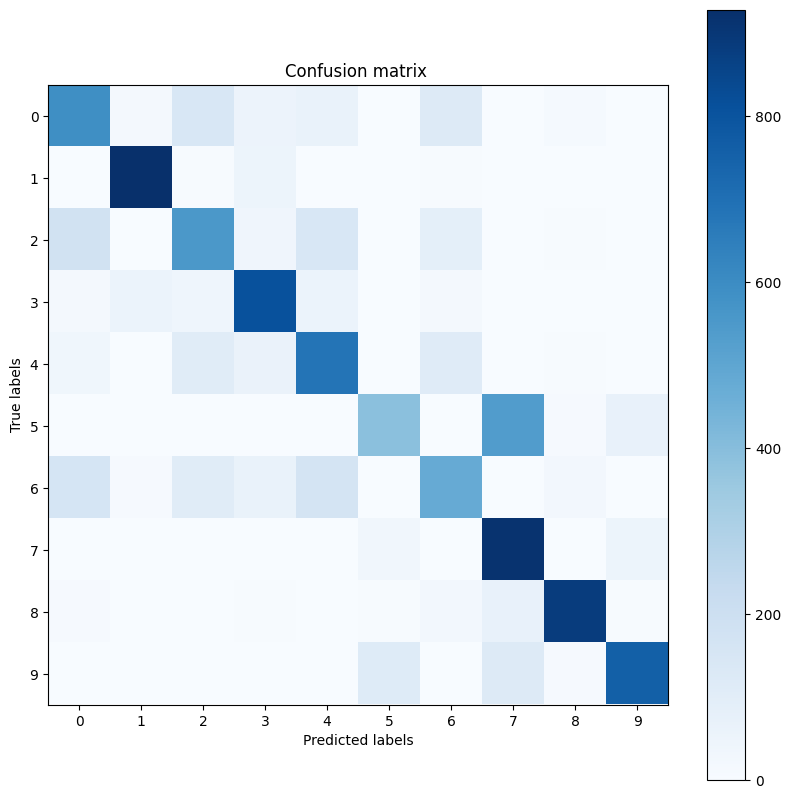

In [163]:
get_classification_report(test_set, clf_cnn_2)

#### 2dn model

In [134]:
class FashionMNISTModel_CNN_2_3(nn.Module):
    def __init__(self):
        super(FashionMNISTModel_CNN_2_3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Flatten(),
            nn.Linear(4*4*16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

In [149]:
clf_cnn_2_3 = FashionMNISTModel_CNN_2_3().to(DEVICE)
opt = optim.Adam(clf_cnn_2_3.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train(clf_cnn_2_3, train_set, val_set, opt, loss_fn, epochs=40, batch_size=32)

>>> Epoch: 1, train_loss: 1.1514185667037964, val_loss: 0.981608510017395, val_accy: 0.6076
>>> Epoch: 2, train_loss: 0.9998089075088501, val_loss: 0.8903069496154785, val_accy: 0.6444
>>> Epoch: 3, train_loss: 0.46190953254699707, val_loss: 0.8253227472305298, val_accy: 0.6702
>>> Epoch: 4, train_loss: 0.6849311590194702, val_loss: 0.790785014629364, val_accy: 0.6825
>>> Epoch: 5, train_loss: 0.7472310066223145, val_loss: 0.7908703088760376, val_accy: 0.6819
>>> Epoch: 6, train_loss: 0.957211971282959, val_loss: 0.7945881485939026, val_accy: 0.6811


KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.63      0.48      0.55      1000
           1       0.94      0.89      0.92      1000
           2       0.56      0.50      0.53      1000
           3       0.71      0.83      0.76      1000
           4       0.63      0.56      0.59      1000
           5       0.73      0.35      0.47      1000
           6       0.47      0.61      0.53      1000
           7       0.54      0.95      0.69      1000
           8       0.91      0.88      0.90      1000
           9       0.87      0.70      0.77      1000

    accuracy                           0.68     10000
   macro avg       0.70      0.68      0.67     10000
weighted avg       0.70      0.68      0.67     10000



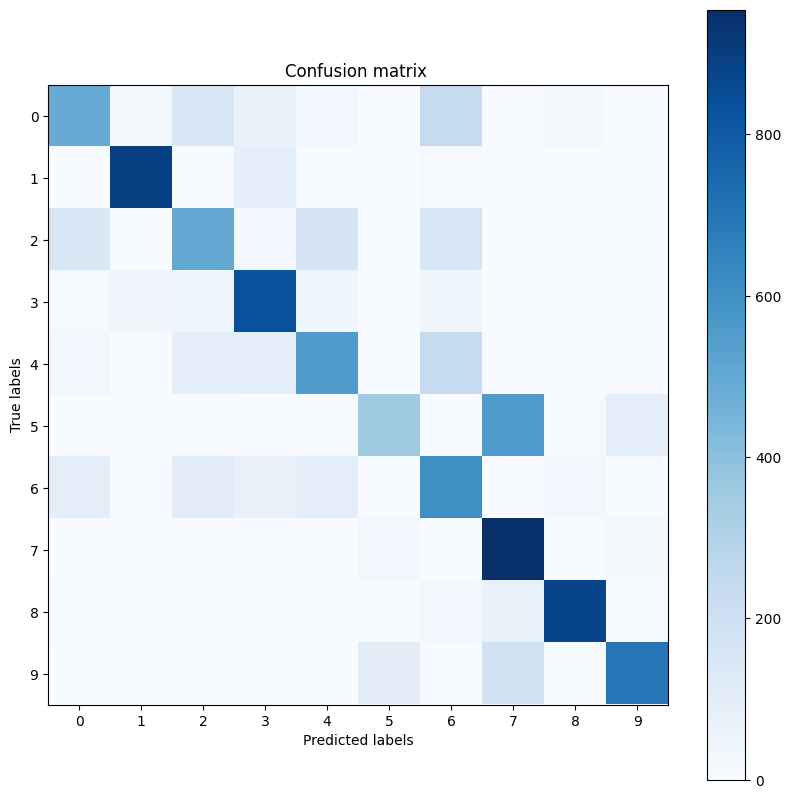

In [150]:
get_classification_report(test_set, clf_cnn_2_3)

#### 3rd model

In [144]:
class FashionMNISTModel_CNN_5_3(nn.Module):
    def __init__(self):
        super(FashionMNISTModel_CNN_5_3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*(28-6)*(28-6), 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

In [146]:
clf_cnn_5_3 = FashionMNISTModel_CNN_5_3().to(DEVICE)
opt = optim.SGD(clf_cnn_5_3.parameters(), lr=1e-2, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

train(clf_cnn_5_3, train_set, val_set, opt, loss_fn, epochs=25, batch_size=32)

>>> Epoch: 1, train_loss: 0.7938622832298279, val_loss: 0.8644985556602478, val_accy: 0.6496
>>> Epoch: 2, train_loss: 0.8800221681594849, val_loss: 0.7966861724853516, val_accy: 0.6796
>>> Epoch: 3, train_loss: 0.23199087381362915, val_loss: 0.7611232995986938, val_accy: 0.6951
>>> Epoch: 4, train_loss: 0.7280253767967224, val_loss: 0.7427827715873718, val_accy: 0.7052
>>> Epoch: 5, train_loss: 0.6784623861312866, val_loss: 0.7428914308547974, val_accy: 0.7094
>>> Epoch: 6, train_loss: 0.8612521886825562, val_loss: 0.7669576406478882, val_accy: 0.6932
>>> Epoch: 7, train_loss: 0.7250190377235413, val_loss: 0.7642812728881836, val_accy: 0.7013
>>> Epoch: 8, train_loss: 0.6795806288719177, val_loss: 0.8401949405670166, val_accy: 0.684
>>> Epoch: 9, train_loss: 0.5498574376106262, val_loss: 0.8155153393745422, val_accy: 0.6931
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\mathe\OneDrive\Documentos\reporitories\ShawAndPartners_MNIST\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\mathe\AppData\Local\Temp\ipykernel_19568\1118195793.py", line 5, in <module>
    train(clf_cnn_5_3, train_set, val_set, opt, loss_fn, epochs=25, batch_size=32)
  File "C:\Users\mathe\AppData\Local\Temp\ipykernel_19568\2689560664.py", line 33, in train
    opt.step()
  File "c:\Users\mathe\OneDrive\Documentos\reporitories\ShawAndPartners_MNIST\.venv\lib\site-packages\torch\optim\optimizer.py", line 280, in wrapper
    else:
  File "c:\Users\mathe\OneDrive\Documentos\reporitories\ShawAndPartners_MNIST\.venv\lib\site-packages\torch\optim\optimizer.py", line 33, in _use_grad
    .. warning::
  File "c:\Users\mathe\OneDrive\Documentos\reporitories\ShawAndPartners_MNIST\.venv\lib\site-packages\torch\optim\sgd.py", line 76, in step

              precision    recall  f1-score   support

           0       0.58      0.55      0.57      1000
           1       0.90      0.92      0.91      1000
           2       0.56      0.51      0.53      1000
           3       0.76      0.78      0.77      1000
           4       0.59      0.70      0.64      1000
           5       0.76      0.37      0.50      1000
           6       0.52      0.47      0.49      1000
           7       0.56      0.92      0.70      1000
           8       0.94      0.86      0.90      1000
           9       0.85      0.79      0.82      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.68     10000
weighted avg       0.70      0.69      0.68     10000



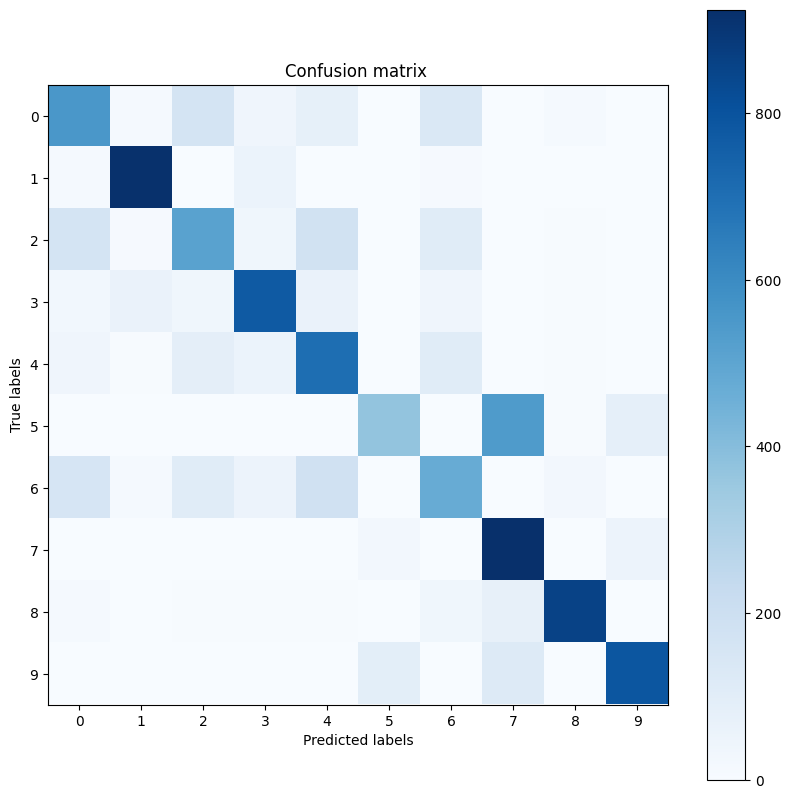

In [147]:
get_classification_report(test_set, clf_cnn_5_3)

## Save Model

Analyzing the results, the best model was the 3th one from CNN models. The metrics was very close, but that model had the best metrics for all classes looking for the f1-score in each class.

In [169]:
BEST_MODEL = clf_cnn_5_3

In [170]:
BASE_PATH = pathlib.Path().resolve().parent / 'models'
BASE_PATH

WindowsPath('C:/Users/mathe/OneDrive/Documentos/reporitories/ShawAndPartners_MNIST/models')

In [171]:
# Save model weights and architecture in a .pt file
MODEL_FOLDER_PATH = pathlib.Path().resolve().parent / 'models'
MODEL_NAME = 'model.pt'

# Create the folder if it doesn't exist
if not MODEL_FOLDER_PATH.exists():
    MODEL_FOLDER_PATH.mkdir()

# Save the model
torch.save(BEST_MODEL.state_dict(), pathlib.Path(MODEL_FOLDER_PATH, MODEL_NAME))

#### ❗ IMPORTANT ❗ ####

**You have to copy the model class implementation on ```/models/model_class.py```, changing the model name to ```ModelClass```.** 

Follow the pattern bellow:

```py
# model_class.py
from torch import nn
IMAGE_SIZE = 28 * 28
class ModelClass(nn.Module):
    # <Insert here the class code>
```

That step is important to use the model on FastAPI.